## XAI with LIME

In [2]:
!pip install lime

     ---------------------------------------- 0.0/275.7 kB ? eta -:--:--
     ---- ---------------------------------- 30.7/275.7 kB 1.4 MB/s eta 0:00:01
     --------------------- ---------------- 153.6/275.7 kB 1.8 MB/s eta 0:00:01
     -------------------------------------- 275.7/275.7 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283846 sha256=a03be372c05babd0213083f9b4c9f11c712647ee26b7633d0ae15a5c99bc4e45
  Stored in directory: c:\users\home\appdata\local\pip\cache\wheels\85\fa\a3\9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [3]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
from IPython.display import Image, display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

import lime
from lime import lime_image
from lime import submodular_pick

from skimage.segmentation import mark_boundaries

np.random.seed(123)

### Loading the data

Since we are more interested to check how black-box image classifiers can be explained using LIME, we will focus only on the inference part. Let us load any generic image data. For this example, we will take the data from this source: https://i.imgur.com/1Phh6hv.jpeg

458011/458011 [==============================] - 0s 0us/step


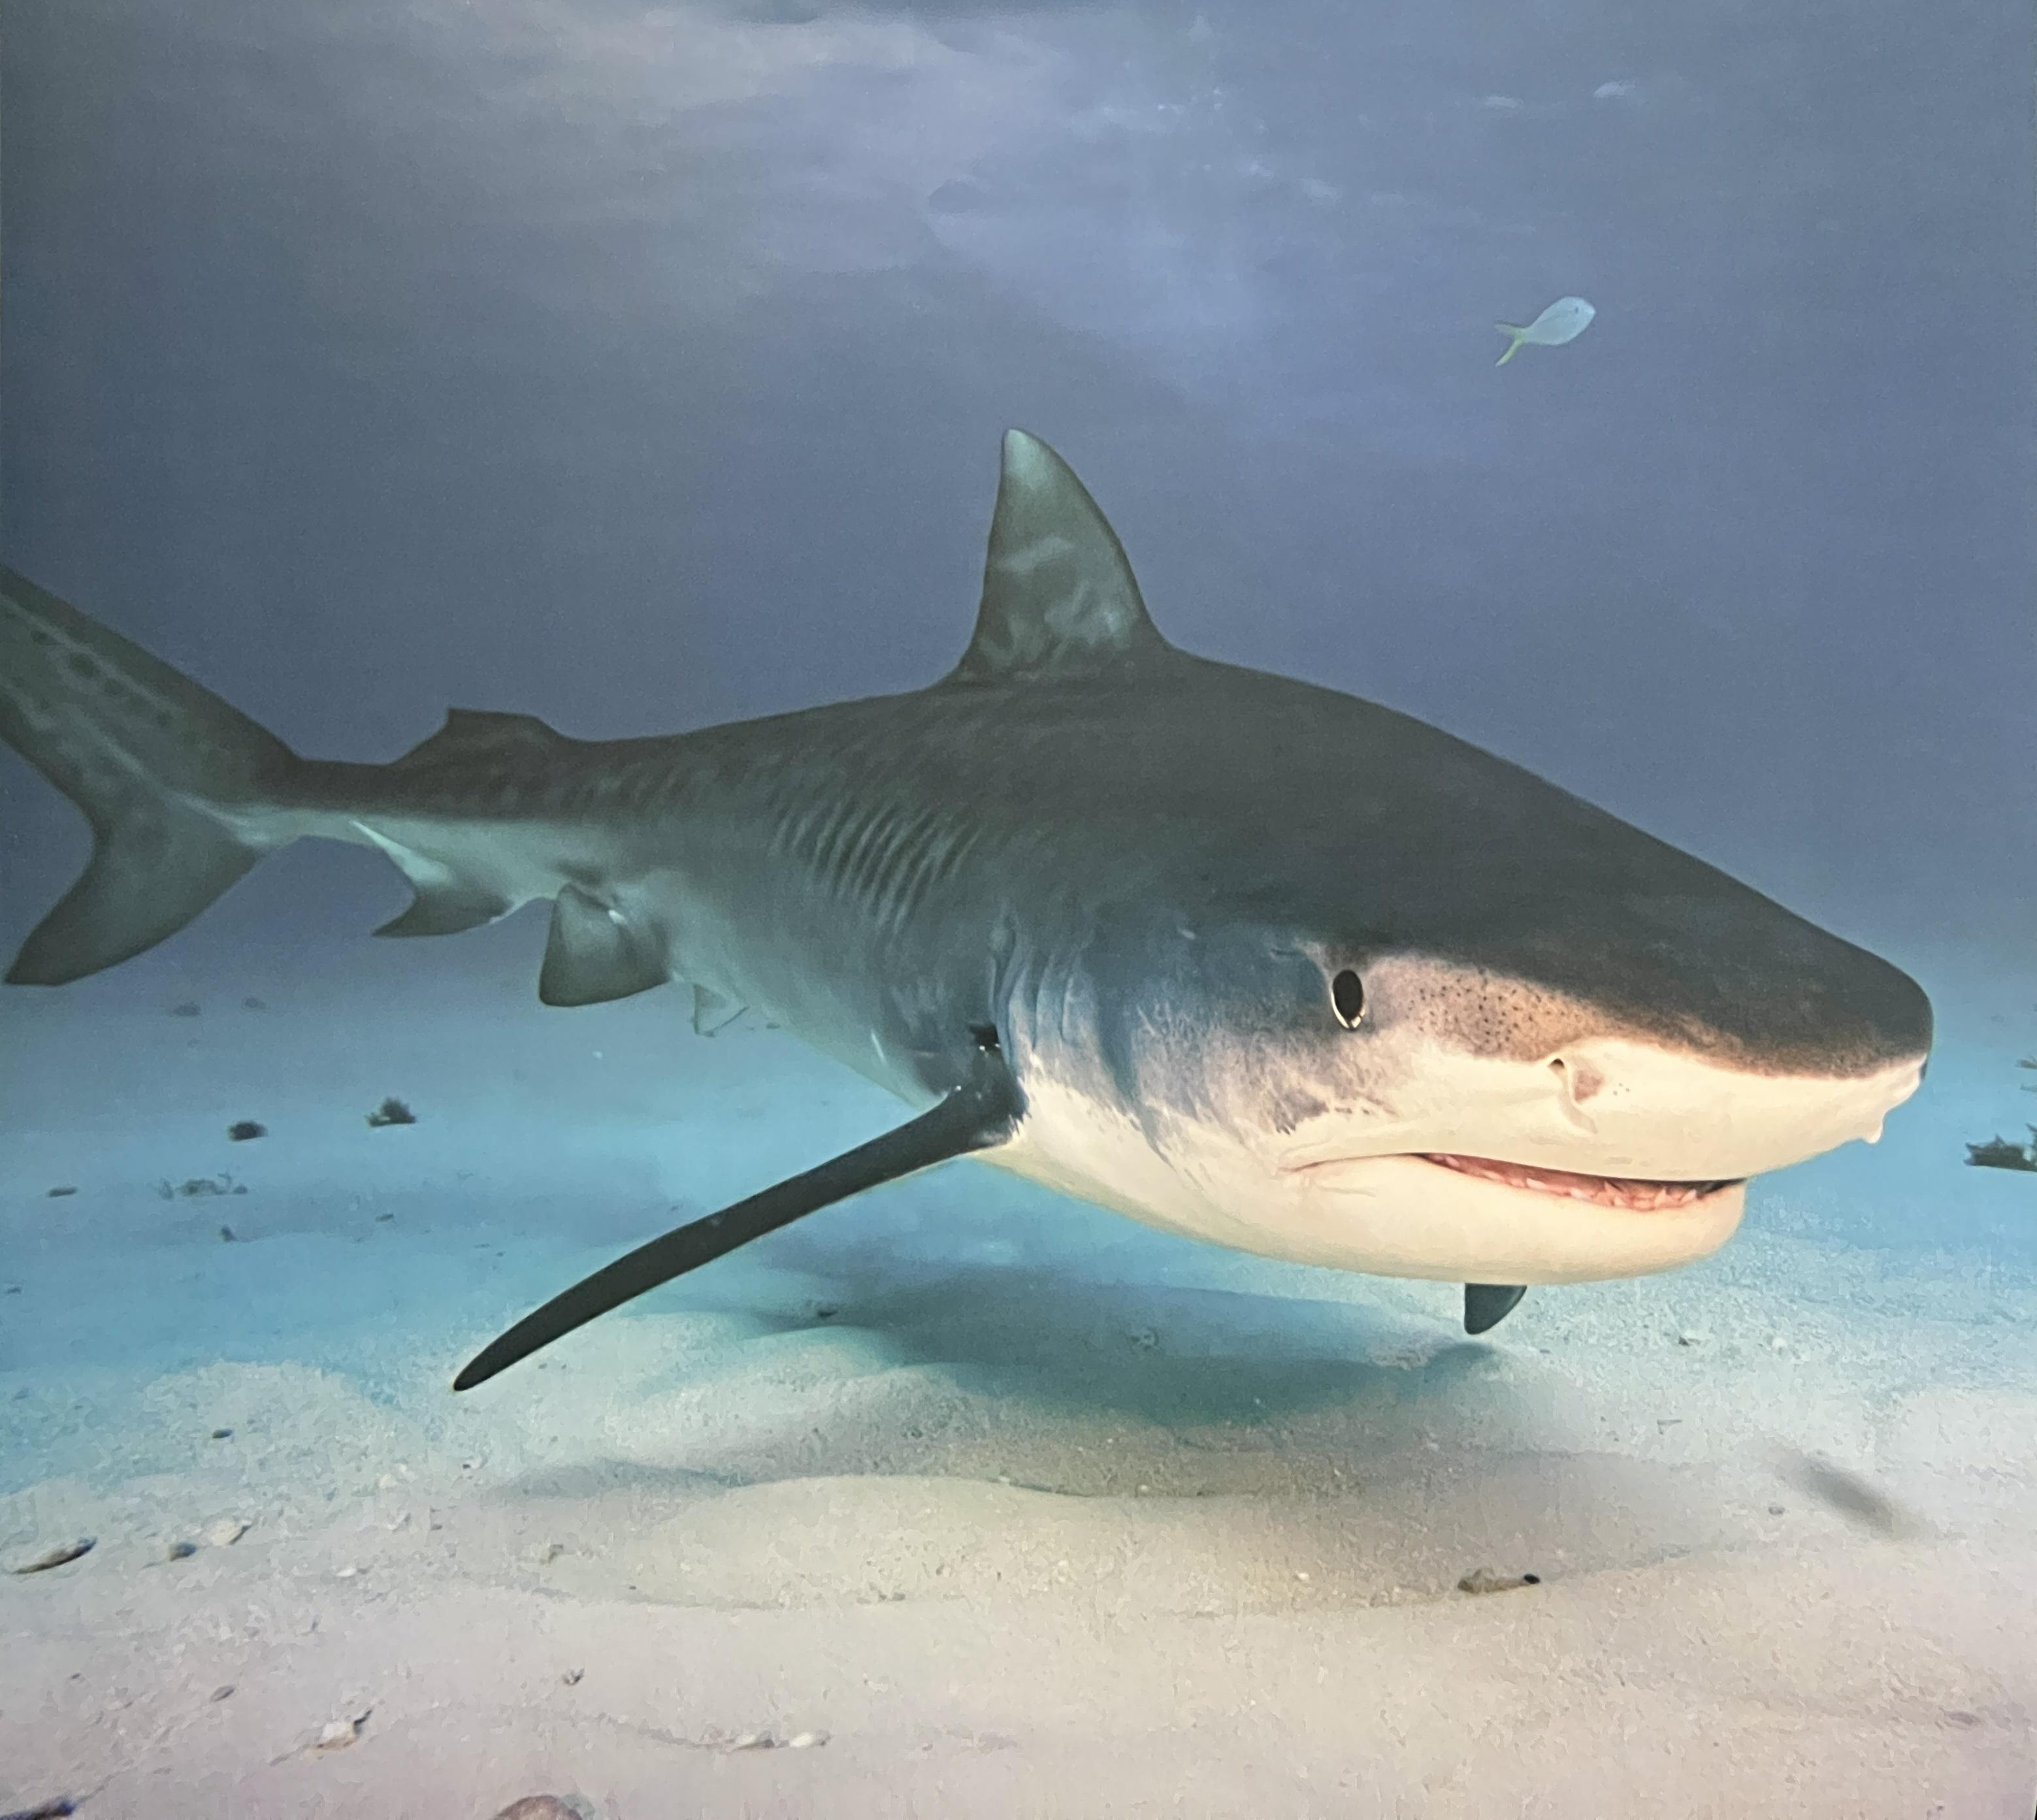

In [4]:
def load_image_data_from_url(url):
    '''
    Function to load image data from online
    '''
    # The local path to our target image
    image_path = keras.utils.get_file(
    "shark.jpg", url
    )

    display(Image(image_path))
    return image_path

image_path = load_image_data_from_url(url = "https://i.imgur.com/1Phh6hv.jpeg")

We will perform some initial data pre-processing with images.

In [21]:
IMG_SIZE = (299, 299)
im = image.load_img(image_path, target_size=(299, 299))
im = image.img_to_array(im)
im = np.expand_dims(im, axis=0)
im.shape

(1, 299, 299, 3)

In [30]:
IMG_SIZE = (299, 299)
def transform_image(image_path, size):
    '''
    Function to transform an image to normalized numpy array
    '''
    img = image.load_img(image_path, target_size=size)
    img = image.img_to_array(img)# Transforming the image to get the shape as [channel, height, width]
    img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    img = img/255.0 # normalizing the image to keep within the range of 0.0 to 1.0
    
    return img

normalized_img = transform_image(image_path, IMG_SIZE)
normalized_img[0].shape

(299, 299, 3)

### Defining the model
For this example, we are not training a model from scratch, but rather defining a pretrained Tensorflow Xception model as our black-box Deep Learning model which we will be explaining using the LIME framework.

In [23]:
from tensorflow.keras.applications.xception import Xception
model = Xception(weights="imagenet")

91884032/91884032 [==============================] - 14s 0us/step


In [45]:
model_pred = model.predict(normalized_img)

model_pred


1/1 [==============================] - 0s 161ms/step


array([[2.51484234e-05, 5.78561849e-05, 5.71859907e-03, 9.33318496e-01,
        1.20445818e-03, 1.18745796e-04, 2.44070325e-04, 6.64103572e-05,
        7.51384869e-05, 3.94529852e-05, 9.85468650e-05, 2.56312542e-05,
        8.35971223e-05, 2.28251563e-04, 3.18004422e-05, 9.81726771e-05,
        3.66142340e-05, 3.17650083e-05, 3.01301425e-05, 2.68019830e-05,
        4.48251158e-05, 6.17868500e-05, 3.02968292e-05, 3.17421473e-05,
        6.41235238e-05, 3.80582933e-05, 2.00453025e-04, 1.06713407e-04,
        6.82451428e-05, 4.44386591e-04, 6.36951809e-05, 5.61811612e-05,
        3.61307648e-05, 6.11517971e-05, 1.47324690e-05, 4.32121124e-05,
        1.08124996e-05, 4.05284554e-05, 1.19439290e-04, 3.34899232e-05,
        9.07009889e-05, 1.36839255e-04, 2.16607605e-05, 5.07787881e-05,
        5.40724541e-05, 3.58084908e-05, 6.15184399e-05, 3.37115089e-05,
        4.08586748e-05, 4.32598172e-05, 7.68202081e-05, 4.74617991e-05,
        5.46421616e-05, 4.08461710e-05, 7.83679279e-05, 6.186892

35363/35363 [==============================] - 0s 1us/step
The predicted class is : tiger_shark


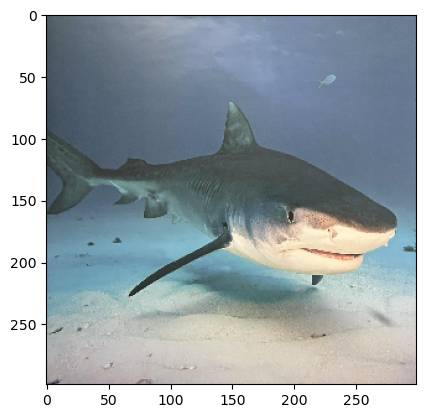

In [24]:
def get_model_predictions(data):
    model_prediction = model.predict(data)
    print(f"The predicted class is : {decode_predictions(model_prediction, top=1)[0][0][1]}")
    return decode_predictions(model_prediction, top=1)[0][0][1]

plt.imshow(normalized_img[0])
pred_orig = get_model_predictions(normalized_img)

The image is predicted as Tiger Shark which is the correct prediction and the black-box model is successfully able to give the correct prediction. Now, let us even take a look at the top 5 predictions along with the model confidences.

In [105]:
model_prediction = model.predict(normalized_img)
top5_pred = decode_predictions(model_prediction, top=5)[0]
for pred in top5_pred:
    print(pred[1])

1/1 [==============================] - 0s 159ms/step
tiger_shark
great_white_shark
hammerhead
scuba_diver
sturgeon


As we see, although the model is well trained to produce the correct prediction, but there are chances that the model is not just looking into main object in the image but as well as the surrounding background. This is evident from the prediction of scuba_driver present in the top 5 prediction list. So, it is important for us understand, the key components or parts of the image the model is looking into to make the prediction.

### Model Explanation with LIME
Now, we will use the LIME framework to identify "super-pixels" or image segments used by the model to predict the outcome.

In [46]:
explainer = lime_image.LimeImageExplainer()

In [49]:
exp = explainer.explain_instance(normalized_img[0], 
                                 model.predict, 
                                 top_labels=5, 
                                 hide_color=0, 
                                 num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


Our explainer object is ready, but let us visualize the various explanation segments created by the LIME algorithm.

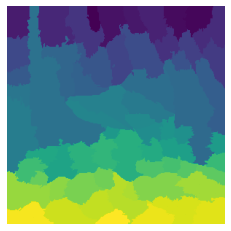

In [19]:
plt.imshow(exp.segments)
plt.axis('off')
plt.show()

Now, let us use the top segments or super pixels to identify the region of interest of the image used by the model to make its prediction.

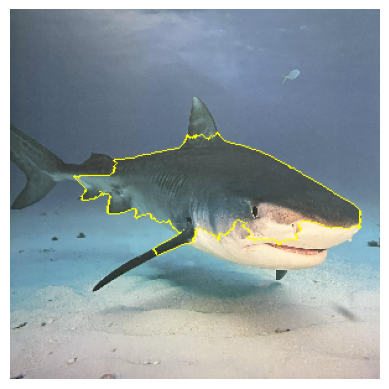

[3, 2, 4, 983, 394]


In [100]:
def gps(exp, exp_class, weight = 0.1, show_positive = True, hide_background = True):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    image, mask = exp.get_image_and_mask(exp_class, 
                                         positive_only=show_positive, 
                                         num_features=6, 
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    plt.imshow(mark_boundaries(image, mask))
    plt.axis('off')
    plt.show()
    
gps(exp, exp.top_labels[0], show_positive = True, hide_background = False)
print(exp.top_labels)# not responding to other label ?why

In [66]:
def generate_prediction_sample(exp, exp_class, weight = 0.1, show_positive = True, hide_background = True):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    image, mask = exp.get_image_and_mask(exp_class, 
                                         positive_only=show_positive, 
                                         num_features=6, 
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    plt.imshow(mark_boundaries(image, mask))
    plt.axis('off')
    plt.show()


In [80]:
exp

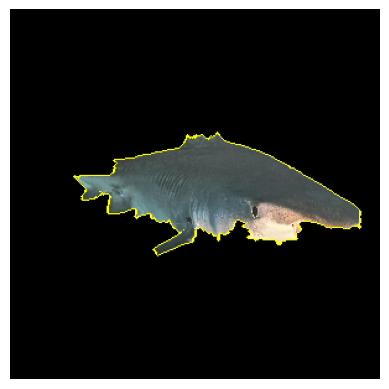

In [67]:
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = True)

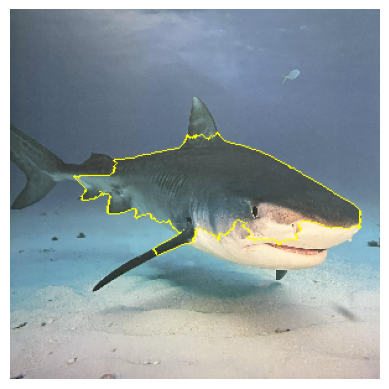

In [101]:
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = False)

As we can see from the above image that the model was able to identify the correct region, which does indicate the correct prediction of the outcome by the model.

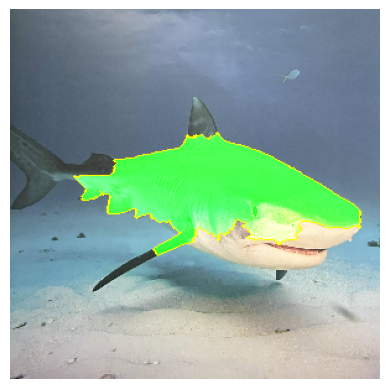

In [102]:
generate_prediction_sample(exp, exp.top_labels[0], show_positive = False, hide_background = False)

The above samples show us how we can hide or show the background along with the super-pixels or even outline or highlight the super-pixels to identify the region of interest used by the model to make the prediction. What we see from here does make sense, and does allow us to increase trust towards black-box models. We can also form a heat-map to show how important each super-pixel is to get some more granular explaianbility.

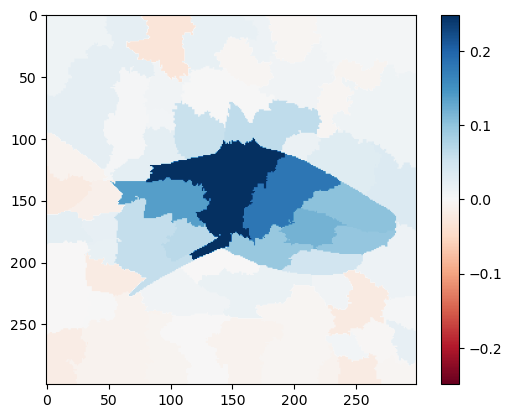

In [103]:
def explanation_heatmap(exp, exp_class):
    '''
    Using heat-map to highlight the importance of each super-pixel for the model prediction
    '''
    dict_heatmap = dict(exp.local_exp[exp_class])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments) 
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.show()

explanation_heatmap(exp, exp.top_labels[0])

We can clearly identify the most influential segments used by the model to make the prediction using this heatmap visualization.

Now, let try to perform the same steps for another explanation class and see if the results are different.

In [111]:
top5_pred

[('n01491361', 'tiger_shark', 0.9333185),
 ('n01484850', 'great_white_shark', 0.005718599),
 ('n01494475', 'hammerhead', 0.0012044582),
 ('n10565667', 'scuba_diver', 0.0008832593),
 ('n02640242', 'sturgeon', 0.0006529992)]

In [114]:
index = 2
print(f"We will deal with predicted class: {top5_pred[2][1]}")

We will deal with predicted class: hammerhead


We will deal with predicted class: hammerhead

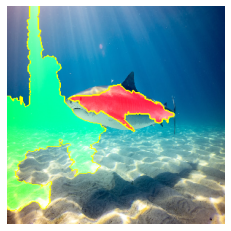

In [16]:
generate_prediction_sample(exp, exp.top_labels[index], weight = 0.0001, show_positive = False, hide_background = False)


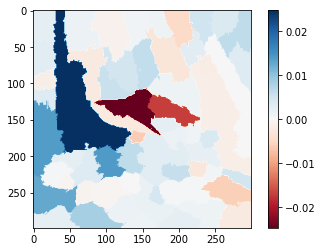

In [17]:
explanation_heatmap(exp, exp.top_labels[index])